In [1]:
%matplotlib notebook 

import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c

from axiprop.lib import PropagatorSymmetric, PropagatorResampling
from axiprop.utils import laser_from_fu, mirror_parabolic

## Laser and focussing system parameters

In [2]:
lambda0 = 0.8e-6              # wavelength [m]
tau_fwhm = 35e-15             # FWHM duration (intensity) [s]
R_las = 10e-3                 # Radial size of laser [m]

tau = tau_fwhm / (2*np.log(2))**0.5
k0 = 2 * np.pi / lambda0

def fu_laser(r, kz):
    """
    Gaussian spot with the Gaussian temporal profile
    """
    profile_r = np.exp( -(r/R_las)**2 ) * (r<3.5*R_las)
    profile_kz = np.exp( -( (kz-k0) * c * tau / 2 )**2 )
    return profile_r * profile_kz

f_N = 40                      # f-number of the parabolic mirror
f0 = 2 * R_las * f_N          # focal length

## Simulation domain and propagator

In [3]:
"""
L_kz = 8 / (c*tau)             # full spectral width [1/s] 
Nkz = 1                        # number of kz modes

w0 = 2/np.pi * lambda0 * f_N   # beam waist
L_R = np.pi * w0**2/lambda0    # Rayleigh length
dr = w0/16                     # estimate grid resolution

Rmax = 2.5 * R_las             # total radius [m]
Nr = int( Rmax / dr )          # total radial grid number
Nr_end = int( 12*w0 / dr)      # radial grid number around focus

prop = PropagatorSymmetric(Rmax, L_kz, Nr, Nkz, k0,  Nr_end)
""";

### (alternatively try PropagatorResampling)

In [4]:
L_kz = 8 / (c*tau)             # full spectral width [1/s] 
Nkz = 1                        # number of kz modes

w0 = 2/np.pi * lambda0 * f_N   # beam waist
L_R = np.pi * w0**2/lambda0    # Rayleigh length
dr = w0/4                      # estimate grid resolution (can be smaller than for PropagatorSymmetric)
Rmax = 2.5 * R_las             # total radius [m]
Nr = int( Rmax / dr )          # total radial grid number
Rmax_new = 12*w0               # new radial grid size around focus
Nr_end = 256                   # new radial grid number around focus

prop = PropagatorResampling(Rmax, L_kz, Nr, Nkz, k0, Rmax_new, Nr_end)

## Single-step simulation

- CREATE THE LASER
- REFLECT IT FROM PARABOLIC MIRROR
- PROPAGATE TO THE FOCUS

In [5]:
A0 = laser_from_fu( fu_laser, prop.r, prop.kz, normalize=True )
A0 /=  (R_las/w0) # normalise to the focussed amplitude
A0 = A0 * mirror_parabolic( f0, prop.r, prop.kz )
A0 = prop.step(A0, f0)

In [6]:
val = (np.abs(A0)**2).sum(0)
coord = prop.r_new/w0


np.average(coord**2, weights=val)**.5 * 2.

1.0450550049672398

<IPython.core.display.Javascript object>


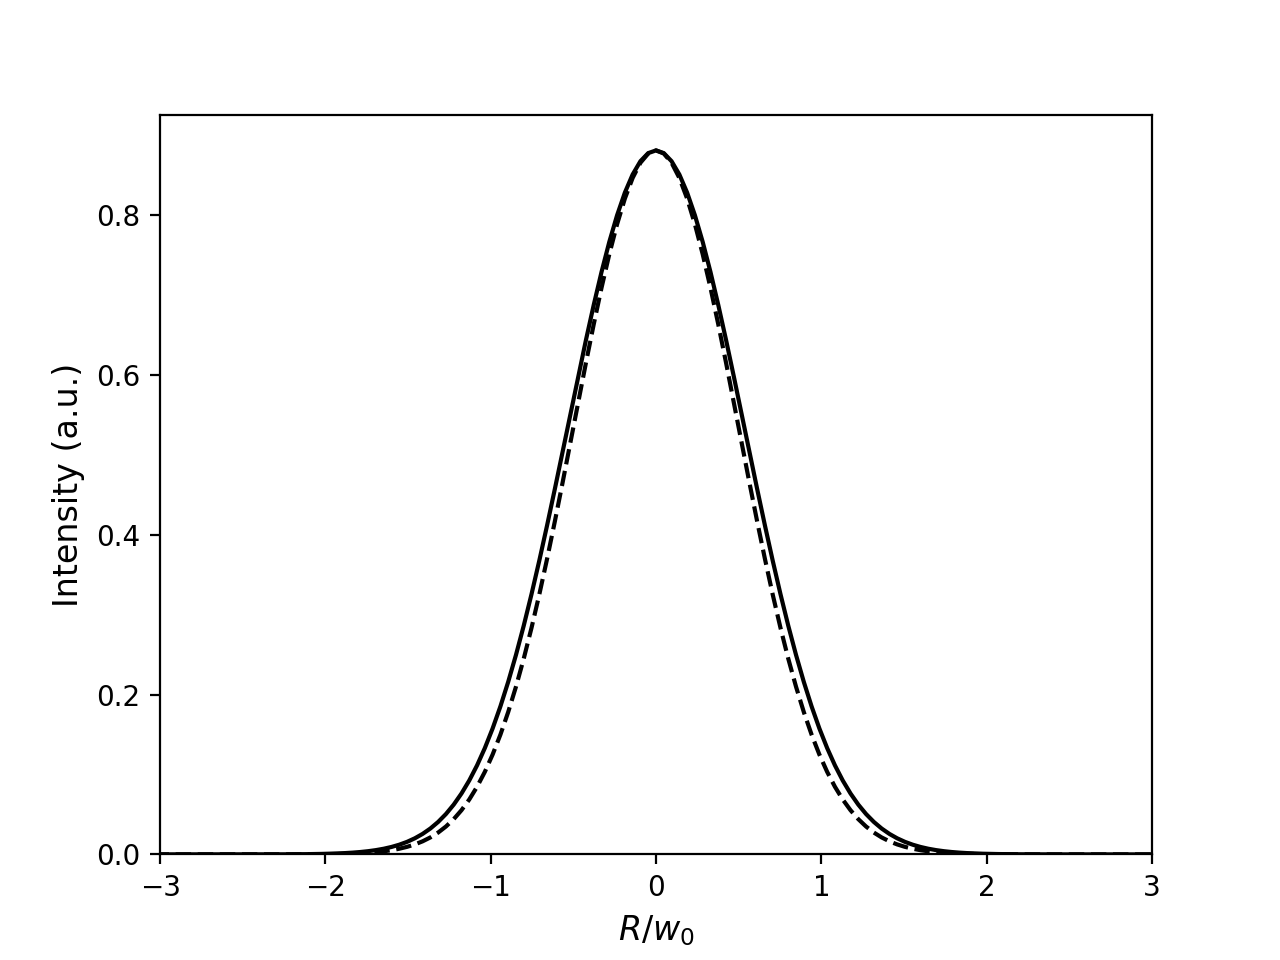

In [7]:
val = (np.abs(A0)**2).sum(0)
val = np.r_[val[::-1], val]
coord = np.r_[-prop.r_new[::-1], prop.r_new]/w0

plt.figure()
plt.plot(coord, val, c='k', lw=1.5)
plt.plot(coord, val.max()*np.exp(-2*coord**2), '--', c='k')

plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.xlabel('$R/w_0$', fontsize=12)

plt.xlim(-3,3)
plt.ylim(0,);

## Multi-step simulation

- CREATE THE LASER
- REFLECT IT FROM THE PARABOLIC MIRROR
- PROPAGATE AROUND THE FOCUS

In [8]:
A0 = laser_from_fu( fu_laser, prop.r, prop.kz, normalize=True )
A0 /=  (R_las/w0)
A0 = A0 * mirror_parabolic( f0, prop.r, prop.kz )

Nsteps = 80
Distance = 8 * L_R

dz =  Distance / Nsteps
zsteps = Nsteps * [dz,]
zsteps[0] = f0 - Distance/2
z_axis = np.cumsum(zsteps)
R2 = (prop.r_new/w0)**2

A_multi = prop.steps(A0, zsteps)

Propagating:


In [9]:
IntesityPropagation = np.zeros((Nsteps, Nr_end))
waist = np.zeros((Nsteps))

for istep in range(Nsteps):
    val = (np.abs(A_multi[istep])**2).sum(0)
    IntesityPropagation[istep,:] = val
    waist[istep] = 2*np.average(R2, weights=val)**0.5

IntesityPropagation = np.array(IntesityPropagation)
FieldPropagation = IntesityPropagation**0.5

<IPython.core.display.Javascript object>


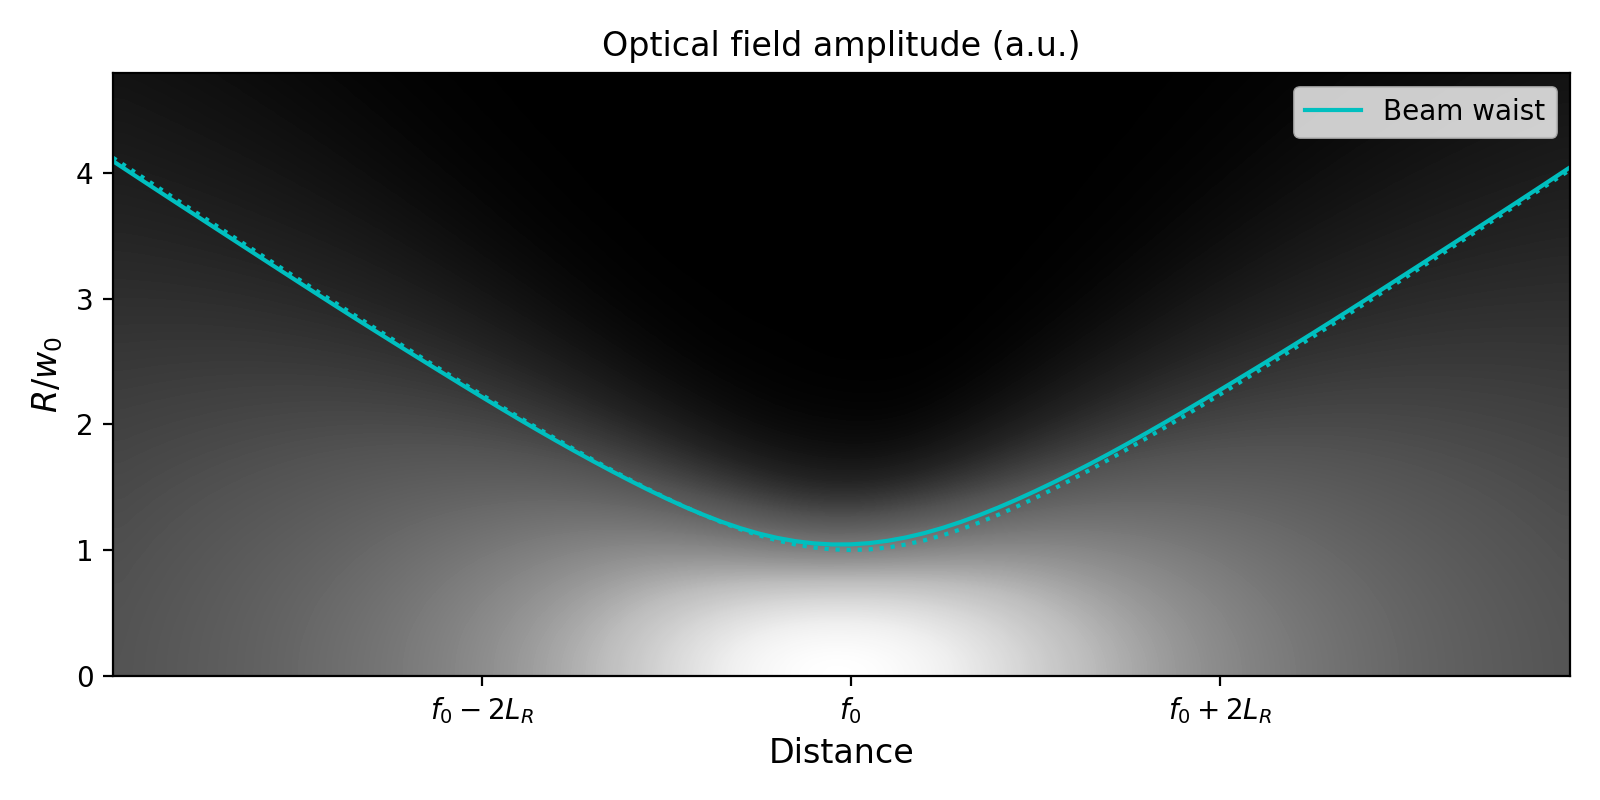

In [10]:
plt.figure(figsize=(8,4), tight_layout=True)

plt.imshow(FieldPropagation.T, 
           extent=[ zsteps[0]*1e3, sum(zsteps)*1e3, 0, prop.r_new.max()/w0 ],
           aspect='auto', origin='lower', interpolation='gaussian',
           cmap=plt.cm.Greys_r)

plt.plot(z_axis*1e3, waist, c='c')
plt.plot(z_axis*1e3, ( 1 + ((z_axis-f0)/L_R)**2 )**.5, ':', c='c' )
plt.legend(('Beam waist',))

plt.xticks(np.array([f0-2*L_R, f0, f0+2*L_R])*1e3, 
           (r'$f_0-2L_R$', r'$f_0$', r'$f_0+2L_R$',))

plt.title('Optical field amplitude (a.u.)',fontsize=12)
plt.xlabel('Distance', fontsize=12)
plt.ylabel('$R/w_0$', fontsize=12)
plt.ylim(0, 4.8);